In [ ]:
# https://www.kaggle.com/ludobenistant/hr-analytics

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv("../data/HR.csv")

In [3]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


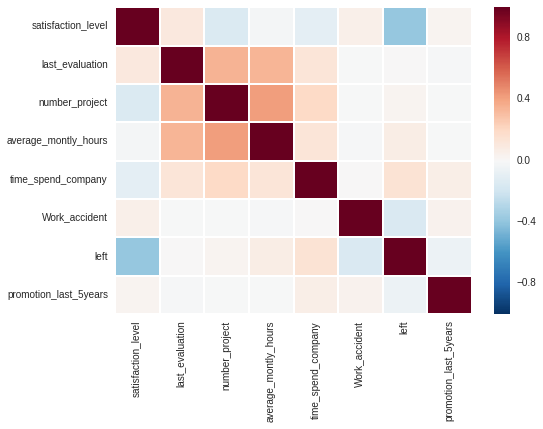

In [4]:
sns.heatmap(df.corr())

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["satisfaction_level", "number_project", "average_montly_hours"]].values, df["left"].values,
    train_size = 0.8, random_state = 1
)

In [6]:
model_poly = make_pipeline(PolynomialFeatures(3), LinearRegression())
model_poly.fit(X_train, y_train)
predictions = model_poly.predict(X_test)
predictions = np.vectorize(lambda x: 0 if x <= 0.5 else 1)(predictions)

In [7]:
print(sum(predictions == y_test), y_test.shape[0])

(2673, 3000)


In [8]:
# https://docs.google.com/presentation/d/1hqF-aR9hiTNqpLtqB5e3Ds_DRG5m_sE-djjRjTvO3vc/pub?start=false&loop=false&delayms=3000&slide=id.p
# "Designing the Optimal Employee Experience"
# see how bad conditions can be for employees before they quit?
# make regression model, figure out how low pay can be (etc.) for each predicted % of employees leaving